# DataJoint Workflow Calcium Imaging Demo

This notebook demonstrates using DataJoint's open-source Elements packages to build a workflow for
calcium imaging. For a detailed tutorial, please see our tutorial notebooks.

### The Basics:

Any DataJoint workflow can be broken down into basic 3 parts:

- `Insert`
- `Populate` (or process)
- `Analyze`

In this demo we will:
- `Insert` information about an animal subject, recording session, and the parameters related
  to processing calcium imaging data through Suite2p or CaImAn.
- `Populate` tables with outputs of image processing including motion correction,
  segmentation, mask classification, and activity traces.
- `Analyze` the processed data by querying and plotting activity traces.

We'll begin by importing the dependencies, then viewing all the tables in the workflow.
After this, we will insert, populate, and analyze calcium imaging data

In [1]:
# Import Statements

import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

import datajoint as dj
import datetime
import matplotlib.pyplot as plt
import numpy as np
from workflow_calcium_imaging.pipeline import subject, session, scan, imaging

[2023-03-07 02:49:21,187][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2023-03-07 02:49:21,195][INFO]: Connected root@fakeservices.datajoint.io:3306


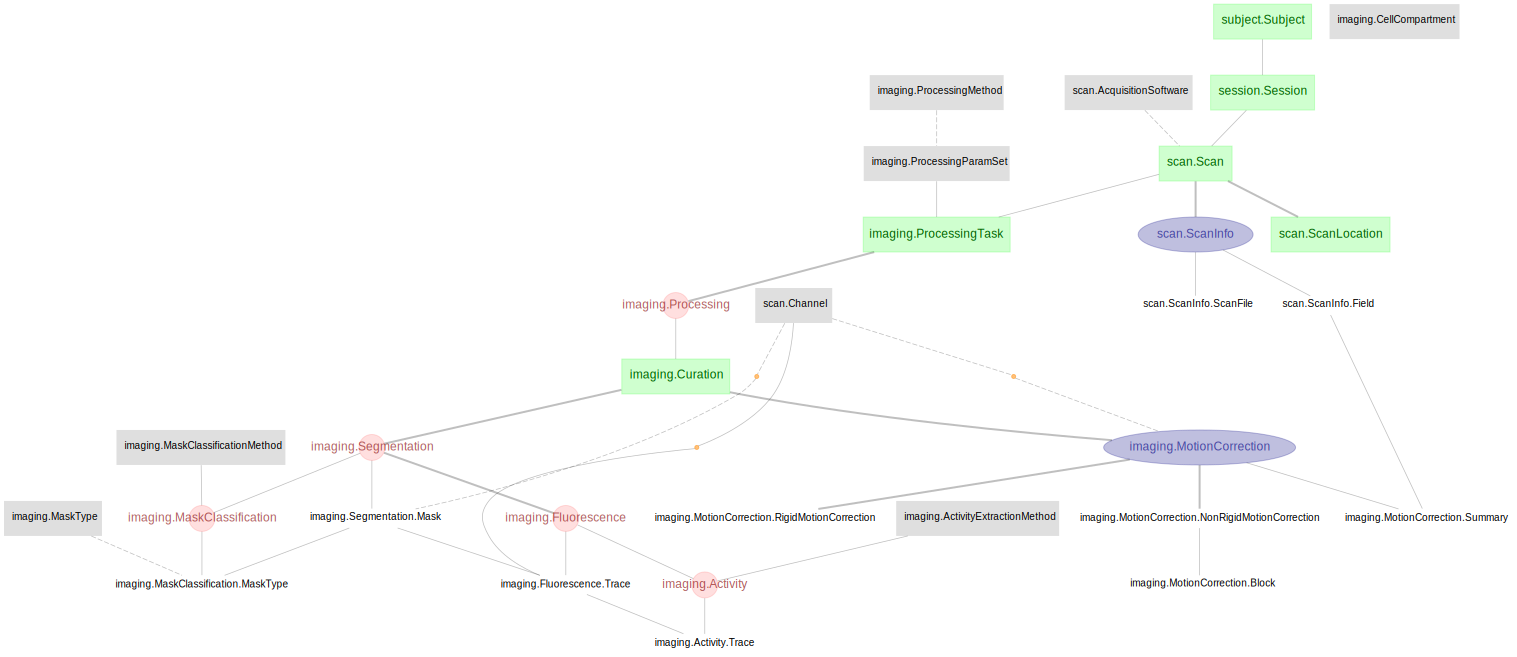

In [2]:
# Run this cell to view a diagram of the tables that we will use in this demo

(
    dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging)
)

### Insert

Below, we begin by inserting data into manual tables including `Subject`, `Session`,
`Scan`, and `ProcessingTask`.

In [3]:
subject.Subject.insert1(
    dict(
        subject='subject1',
        subject_birth_date='2023-01-01',
        sex='U',
    ),
    skip_duplicates=True
)

In [4]:
session.Session.insert1(
    dict(
        subject='subject1',
        session_datetime=datetime.datetime.now()
    )
)

In [6]:
session_key = (session.Session & "subject = 'subject1'").fetch("KEY")[-1]
session.SessionDirectory.insert1(
    dict(
        session_key, 
        session_dir='workspaces/workflow-calcium-imaging/example_data/subject1/session1'
    )
)

In [7]:
scan.Scan.insert1(
    dict(
        session_key,
        scan_id=0,
        acq_software='ScanImage',
    ),
    skip_duplicates=True
)

In [8]:
# Define and insert suite2p parameters

suite2p_params = {
    "look_one_level_down": 0.0,
    "fast_disk": [],
    "delete_bin": False,
    "mesoscan": False,
    "h5py": [],
    "h5py_key": "data",
    "save_path0": [],
    "subfolders": [],
    "functional_chan": 1,
    "tau": 1.0,
    "force_sktiff": True,
    "preclassify": 0.0,
    "save_mat": False,
    "combined": True,
    "aspect": 1.0,
    "do_bidiphase": False,
    "bidiphase": 0.0,
    "do_registration": True,
    "keep_movie_raw": False,
    "nimg_init": 300,
    "batch_size": 500,
    "maxregshift": 0.1,
    "align_by_chan": 1,
    "reg_tif": False,
    "reg_tif_chan2": False,
    "subpixel": 10,
    "smooth_sigma": 1.15,
    "th_badframes": 1.0,
    "pad_fft": False,
    "nonrigid": False,
    "block_size": [128, 128],
    "snr_thresh": 1.2,
    "maxregshiftNR": 5.0,
    "1Preg": False,
    "spatial_hp": 50.0,
    "pre_smooth": 2.0,
    "spatial_taper": 50.0,
    "roidetect": True,
    "sparse_mode": False,
    "diameter": 12,
    "spatial_scale": 0,
    "connected": True,
    "nbinned": 5000,
    "max_iterations": 20,
    "threshold_scaling": 1.0,
    "max_overlap": 0.75,
    "high_pass": 100.0,
    "inner_neuropil_radius": 2,
    "min_neuropil_pixels": 350,
    "allow_overlap": False,
    "chan2_thres": 0.65,
    "baseline": "maximin",
    "win_baseline": 60.0,
    "sig_baseline": 10.0,
    "prctile_baseline": 8.0,
    "neucoeff": 0.7,
    "xrange": np.array([0, 0]),
    "yrange": np.array([0, 0]),
}

imaging.ProcessingParamSet.insert_new_params(
    processing_method="suite2p",
    paramset_desc='Default parameter set for suite2p',
    params=suite2p_params,
    paramset_idx=0,
)

In [11]:
scan_key = (scan.Scan & "subject = 'subject1'").fetch("KEY")[-1]
imaging.ProcessingTask.insert1(
    dict(
        scan_key,
        paramset_idx=0,
        processing_output_dir='workspaces/workflow-calcium-imaging/example_data/subject1/session1',
        task_mode='trigger',
    ),
    skip_duplicates=True
)

### Populate


At this point, most of the manual tables have the necessary information to run the
automatic data processing routines using the `.populate()` function. This function is
used in the cell below to populate the `ScanInfo` table, and trigger suite2p processing
via the `Processing` table.

In [12]:
populate_settings = {"display_progress": True}
scan.ScanInfo.populate(**populate_settings)
imaging.Processing.populate(**populate_settings)

Processing:   0%|          | 0/1 [00:00<?, ?it/s]

{'data_path': ['/workspaces/workflow-calcium-imaging/example_data/subject1/session1'], 'tiff_list': ['/workspaces/workflow-calcium-imaging/example_data/subject1/session1/example1.tif']}
FOUND BINARIES AND OPS IN ['/workspaces/workflow-calcium-imaging/example_data/subject1/session1/suite2p/plane0/ops.npy']
>>>>>>>>>>>>>>>>>>>>> PLANE 0 <<<<<<<<<<<<<<<<<<<<<<
NOTE: not running registration, plane already registered
binary path: /workspaces/workflow-calcium-imaging/example_data/subject1/session1/suite2p/plane0/data.bin
NOTE: Applying builtin classifier at /usr/local/lib/python3.7/site-packages/suite2p/classifiers/classifier.npy
----------- ROI DETECTION
Binning movie in chunks of length 29
Binned movie of size [103,504,506] created in 2.16 sec.
ROIs: 200, cost: 0.2719, time: 37.3755
ROIs: 400, cost: 0.2142, time: 60.6372
ROIs: 547, cost: 0.1907, time: 79.1914
ROIs: 583, cost: 0.1853, time: 92.2314
ROIs: 599, cost: 0.1835, time: 102.0507
ROIs: 599, cost: 0.4262, time: 107.3006
ROIs: 599, c

Processing: 100%|██████████| 1/1 [02:55<00:00, 175.50s/it]


In [13]:
# Optional Curation Step

processing_key = imaging.Processing.fetch1("KEY")
imaging.Curation.insert1(
    dict(
    processing_key,
    curation_id=0,
    curation_time=datetime.datetime.now(),
    curation_output_dir='workspaces/workflow-calcium-imaging/example_data',
    manual_curation=False,
    )
)

In [14]:
imaging.MotionCorrection.populate(**populate_settings)
imaging.Segmentation.populate(**populate_settings)
imaging.MaskClassification.populate(**populate_settings)
imaging.Fluorescence.populate(**populate_settings)
imaging.Activity.populate(**populate_settings)

Activity: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


### Analyze

The `.populate()` calls in the cell above automatically populated DataJoint tables with
the output of Suite2p. We are now ready to perform exploratory and other downstream
analysis.

Below, we will query some of the data and make a plot of the fluorescence trace and
deconvolved activty trace.

In [18]:
curation_key = imaging.Curation.fetch1("KEY")
query_cells = (
    imaging.Segmentation.Mask * imaging.MaskClassification.MaskType
    & curation_key
    & "mask_center_z=0"
    & "mask_npix > 150"
).proj()

In [19]:
fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch(
    "fluorescence", order_by="mask"
)

activity_traces = (imaging.Activity.Trace & query_cells).fetch("activity_trace", order_by="mask")

sampling_rate = (scan.ScanInfo & curation_key).fetch1("fps")

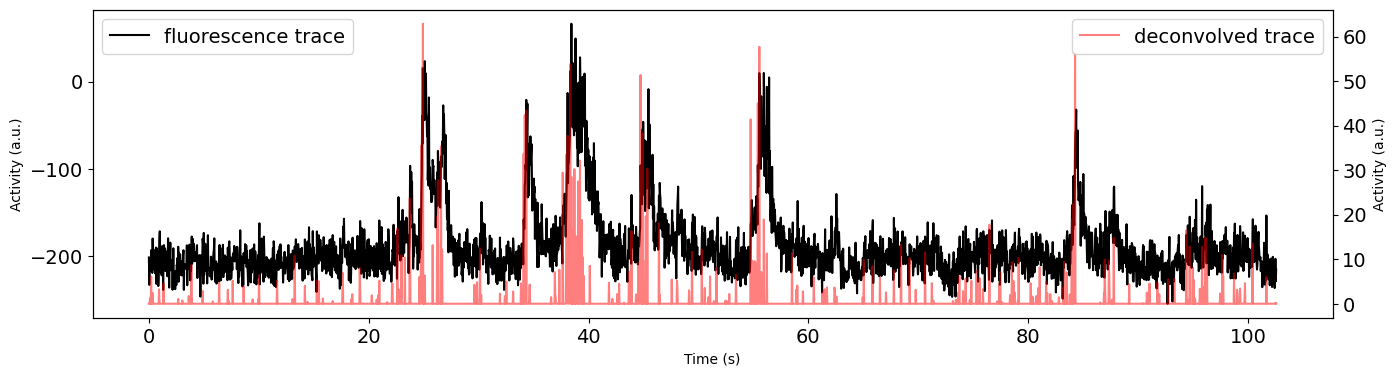

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[: f.size] * 1 / sampling_rate, f, "k", label="fluorescence trace")
    ax2.plot(
        np.r_[: a.size] * 1 / sampling_rate, a, "r", alpha=0.5, label="deconvolved trace"
    )

    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)
ax.legend(loc="upper left", prop={"size": 14})
ax2.legend(loc="upper right", prop={"size": 14})
ax.set_xlabel("Time (s)")
ax.set_ylabel("Activity (a.u.)")
ax2.set_ylabel("Activity (a.u.)");

For a much more in-depth tutorial, be sure to check out our `full_demo.ipynb`.